In [106]:
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [107]:
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [108]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [109]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [110]:
def get_fashion_mnist_labels(labels):
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]



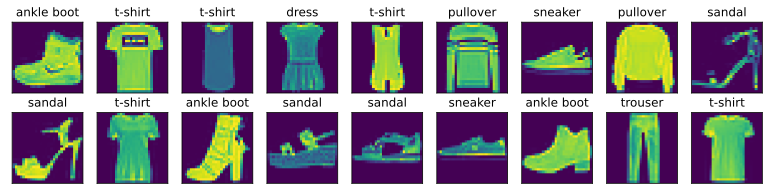

In [111]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
d2l.show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

In [112]:
batch_size = 256

def get_dataloader_workers():

    return 4
train_iter = data.DataLoader(mnist_train, batch_size,shuffle=True, num_workers=get_dataloader_workers())

In [113]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'3.69 sec'

In [114]:
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [115]:
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


In [116]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [117]:
num_inputs = 784
num_outputs = 10

W = torch.normal(0, 0.01, size=(num_inputs, num_outputs), requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)


In [118]:
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

In [119]:
def softmax(X):
    X_exp = torch.exp(X)
    print(X_exp)
    partition = X_exp.sum(1, keepdim=True)
    print(partition)
    print(X_exp / partition)
    return X_exp / partition  # 这里应用了广播机制

In [120]:
X = torch.normal(0, 1, (2, 5))
print(X)
X_prob = softmax(X)
X_prob, X_prob.sum(1)# 

tensor([[-1.2890,  0.4386, -0.8906, -0.9779, -0.2571],
        [-0.4476, -1.2175,  0.3083, -1.1229, -0.7348]])
tensor([[0.2755, 1.5505, 0.4104, 0.3761, 0.7733],
        [0.6392, 0.2960, 1.3611, 0.3253, 0.4796]])
tensor([[3.3858],
        [3.1012]])
tensor([[0.0814, 0.4579, 0.1212, 0.1111, 0.2284],
        [0.2061, 0.0954, 0.4389, 0.1049, 0.1547]])


(tensor([[0.0814, 0.4579, 0.1212, 0.1111, 0.2284],
         [0.2061, 0.0954, 0.4389, 0.1049, 0.1547]]),
 tensor([1., 1.]))

In [121]:
# net 定义网络模型
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

In [122]:
y = torch.tensor([0, 2])  # \实际正确出现的位置
y_hat = torch.tensor([[0.1, 0.3, 0.6], [0.3, 0.2, 0.5]]) # 第一个样本的预测结果，第二个样本的预测结果
y_hat[[0, 1],y]  # 在Yhat中找出第一个样本第二个样本的在预测结果中的位置的值

tensor([0.1000, 0.5000])

In [123]:
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)


tensor([2.3026, 0.6931])

In [124]:
def accuracy(y_hat, y ):
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
        cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())



In [125]:
print('hello')
accuracy(y_hat, y) / len(y)

hello


0.5

In [126]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]
    
def evaluate_accuracy(net, data_iter):
    if isinstance(net, torch.nn.Module):
        net.eval()
    metric = Accumulator(2)
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [127]:
evaluate_accuracy(net, test_iter)

tensor([[0.9478, 1.0169, 1.0885,  ..., 0.9552, 0.8251, 0.9612],
        [0.9504, 1.1342, 1.3895,  ..., 0.9914, 1.1440, 0.9917],
        [0.8721, 1.1657, 1.3661,  ..., 0.8787, 0.9596, 1.0274],
        ...,
        [1.0315, 0.9578, 1.0657,  ..., 0.9940, 0.9999, 0.8915],
        [1.0146, 1.0412, 1.0908,  ..., 0.9103, 0.8556, 0.8510],
        [0.9167, 1.2288, 1.4003,  ..., 1.0179, 1.0448, 0.9732]])
tensor([[ 9.3884],
        [10.0824],
        [10.0989],
        [10.3876],
        [ 9.8820],
        [10.3132],
        [10.1752],
        [ 9.8116],
        [10.2328],
        [10.0062],
        [ 9.9024],
        [ 9.6404],
        [ 9.6056],
        [10.0156],
        [10.1872],
        [10.2155],
        [10.1491],
        [10.3497],
        [ 9.6173],
        [10.1676],
        [10.0712],
        [ 9.8869],
        [ 9.7689],
        [ 9.3241],
        [10.2909],
        [10.0743],
        [10.0398],
        [10.1972],
        [ 9.6017],
        [ 9.9756],
        [ 9.2340],
        [ 9.8

0.1099

In [ ]:
def train_epoch_ch3(net, train_iter, loss, updater):
    """训练模型一个迭代周期"""
    if isinstance(net, torch.nn.Module):
        net.train()
    
    # 训练损失总和，训练准确度总和，样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater. torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]